# Updating Regional Timeseries for OISST Data

**Objective: Update all masked timeseries products to most current OISST data.**

**NOTE! 3/1/2021**
Calculations of anomalies and log-likelihood need to be re-run following the appending step. Currently they are run only using the update data, resulting in untethered anomalies and bad log-likelihood values.

## Product 2: Regional Timeseries of Anomalies

This is the second notebook for updating OISST data products. This series should be run in order, starting with `04_OISST_Update_Global_ts.ipynb`


**New Plan** Run them through the likelihood timeseries pathway. Export the subset as the masked timeseries. Do it in the mainstays folder as a test round, then transfer it over. We need to do the full thing for the NEFSC regions anyways so I could start there first so that I can move forward on size spectra work.

In [12]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import math
import oisstools as ot


# Root paths
root_locations = {"local" : "/Users/akemberling/Box/",
                  "docker" : "/Users/akemberling/Box/"}

# Set the workspace - local/ docker
workspace = "local"
box_root = root_locations[workspace]
print(f"Working via {workspace} directory at: {box_root}")

Working via local directory at: /Users/akemberling/Box/


# Objective 1: Updating LME Timeseries

## Load Regional Polygons
 * Load LME's
 * Load GoM and GB

In [13]:
# This csv contains naming/number structure for the Large Marine Ecosystems
lme_info = pd.read_csv(f"{box_root}NSF OKN Demo Data/large_marine_ecosystems/lme_names_key.csv")
lme_info.head()

# The information below gives the name of the lme and the bounding polygon filename
test_lme = lme_info[lambda df: df["lme_name"] == "Gulf of California"]
test_lme

,lme_number,lme_name,full_poly_file,outer_bound_file
3,4,Gulf of California,LMEbb_04_all.geojson,LMEbb_04_bounding.geojson


## Load existing LME timeseries and associated polygons

Switching to the likelihood timeseries because they contain the climatology information.


In [14]:
# Loading the Timeseries and Mask for Each Large Marine Ecosystem

# File Path Constants:

# Timeseries save folder
out_folder = f"{box_root}RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems"

# LME Mask Locations
mask_root = f"{box_root}NSF OKN Demo Data/large_marine_ecosystems"

# Satellite Data Name
grid_name = "OISSTv2_anom"


# list to catch the dataframes
lme_timeseries = [] # timeseries of masked anomalies
lme_polygons = []   # polygons for the masks


####  Looping through LME's  ####


# Super loop for all the LME's
for i, lme in lme_info.iterrows():
      
    # Names of LME as variable names, fix underscores and caps
    lme_name = lme["lme_name"].replace(" ", "_").replace("-", "_").replace("___", "_").replace("__", "_").lower()  
    
    # Location to polygon file
    poly_path = lme["outer_bound_file"]
    
    # Reconstructed Path to the timeseries
    csv_path = f"{out_folder}/{grid_name}_{lme_name}.csv"
    
    #load the timeseries we want to append to:
    outdated_timeline = pd.read_csv(csv_path)
    outdated_timeline["time"] = pd.to_datetime(outdated_timeline["time"])
    lme_timeseries.append(outdated_timeline)
    
    # Then load the mask
    lme_mask = gpd.read_file(f"{mask_root}/{poly_path}")
    lme_polygons.append(lme_mask)
    

In [15]:
# glimpse the first timeseries
lme_timeseries[0].head()

,time,modified_ordinal_day,sst,sst_clim,sst_anom,clim_sd,log_lik
0,1981-09-01,244,5.126844,5.186733,-0.059889,2.726807,1.922311
1,1981-09-02,245,5.144029,5.179364,-0.035335,2.721179,1.920088
2,1981-09-03,246,5.032818,5.130115,-0.097297,2.675931,1.903897
3,1981-09-04,247,4.911862,5.101026,-0.189164,2.639488,1.892092
4,1981-09-05,248,4.947023,5.053141,-0.106118,2.604544,1.877026


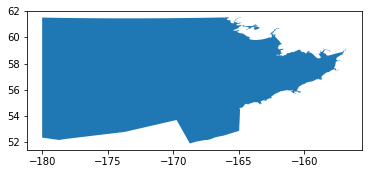

In [16]:
# Plot any of the shapefiles
lme_polygons[0].plot()

## Load the desired update years of OISSTv2 data
 
Loop through the lists of shapes and the new OISST data to create a timeseries of sea surface temperature for each LME.

In [17]:
# Set location to OISST data
oisst_location  = f"{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/"

# start and end years for the update
start_yr = 2020
end_yr = 2020

# variable name to mask and make timeline from
var_name = "sst"

# load the annual files for oisst
fpaths = []
for yr in range(start_yr, end_yr + 1):
    fpaths.append(f'{oisst_location}sst.day.mean.{yr}.v2.nc')
    
# Lazy-load using xr.open_mfdataset
grid_obj = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = False)

## Get regional timeseries of observed SST

Step one is to get a masked timeseries for each of the shapes we are working with. To do this we loop through the different large marine ecosystems, creating a timeline of sst for each one and saving the tables in a list

In [18]:
# list to store them un-appended
new_ts = []

##### Loop for all the LME's and their masks  ####
for i, lme in lme_info.iterrows():
    
    # Grab name of LME from table
    lme_name = lme["lme_name"]
    
    # Format name of LME as variable names, as you would save it
    # no spaces, underscores, and only single underscores between gaps
    shp_name = lme["lme_name"].replace(" ", "_").replace("-", "_").replace("___", "_").replace("__", "_").lower()   
    
    # grab the shape:
    shp_obj = lme_polygons[i]
    
    
    #### 1. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    #### 2. Mask the array with gom_mask to get nan test
    mask = area_mask.mask(grid_obj, lon_name = "lon", lat_name = "lat")

    
    #### 3. Extract data that falls within the mask
    masked_ds = grid_obj.where(~np.isnan(mask))

    
    #### 4. Calculate timeseries mean

    # Get the timeseries mean of the desired variable
    masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))
    
    # Get the standard deviation of the desired variable
    masked_ts[f"{var_name}_stdev"] = getattr(masked_ds, var_name).std(dim = ("lat", "lon"))

    
    
    #### 5. Change time index rownames to a column 

    # Convert to Timeseries Dataframe
    masked_ts_df = masked_ts.to_dataframe()

    # Reset the index, rename variables
    masked_ts_df = masked_ts_df.reset_index()[["time", var_name, f"{var_name}_stdev"]]

    
    #### 6. Store in list
    new_ts.append(masked_ts_df)
    new_ts_names.append(lme_name)
    
    # Update Message
    print(f"Region Processed:   {lme_name}")

East Bering Sea : Processed.
Gulf of Alaska : Processed.
California Current : Processed.
Gulf of California : Processed.
Gulf of Mexico : Processed.
Southeast U.S. Continental Shelf : Processed.
Northeast U.S. Continental Shelf : Processed.
Scotian Shelf : Processed.
Labrador - Newfoundland : Processed.
Insular Pacific-Hawaiian : Processed.
Pacific Central-American Coastal : Processed.
Caribbean Sea : Processed.
Humboldt Current : Processed.
Patagonian Shelf : Processed.
South Brazil Shelf : Processed.
East Brazil Shelf : Processed.
North Brazil Shelf : Processed.
Canadian Eastern Arctic - West Greenland : Processed.
Greenland Sea : Processed.
Barents Sea : Processed.
Norwegian Sea : Processed.
North Sea : Processed.
Baltic Sea : Processed.
Celtic-Biscay Shelf : Processed.
Iberian Coastal : Processed.
Mediterranean Sea : Processed.
Canary Current : Processed.
Guinea Current : Processed.
Benguela Current : Processed.
Agulhas Current : Processed.
Somali Coastal Current : Processed.
Arabi

## Compare update period to existing timeseries

At this point  the update years have been masked for each LME, with the timeseries for each stored in a list. The table format now needs to match that of the existing timeseries so that they can be appended together to create one timeseries.

In [1]:
# # Timeseries calculated previously
# lme_timeseries[0].tail()


In [2]:
# # Timeseries just calculated
# tester_ts = new_ts[0]

# # Add modified ordinal day, for day-to-day calculation and leapyear adjustment
# not_leap_year  = ~tester_ts.time.dt.is_leap_year
# march_or_later = tester_ts.time.dt.month >= 3
# ordinal_day    = tester_ts.time.dt.dayofyear
# mod            =  ordinal_day + (not_leap_year & march_or_later)
# tester_ts["modified_ordinal_day"] = mod


# # check it
# tester_ts.tail()

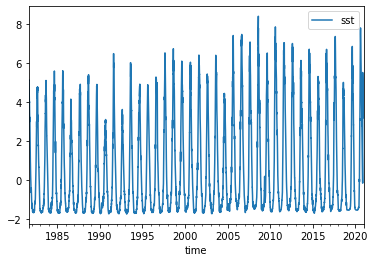

In [35]:
# # Remove dates that overlap from the update timeseries
# not_overlapped = ~tester_ts.time.isin(lme_timeseries[0].time)
# new_ts_test = tester_ts[not_overlapped][["time", "sst"]]


# # Append them on the end if they match
# append_test = pd.concat([ lme_timeseries[0][["time", "sst"]], new_ts_test])
# append_test.plot("time", "sst")

# Matching up the climatology info

The Original timeseries already contains the climate means for each day of the year. This removes the need to load the climatology again and repeat those steps. To accomplish the same thing we can pull unique `sst_clim` and `modified_ordinal_day` values and merge them in to the new data and get the same outcomes.

## Running anomalies with test timeseries :

This code is just a test run for matching up the existing timeseries with the new data.

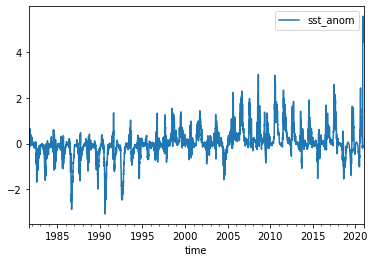

In [36]:
# # Previously calculated timeseries
# old_ts = lme_timeseries[0] 

# #newly calculated timeseries
# tester_ts = new_ts[0] 

# # pull unique climatology values from existing timeline
# clim = old_ts[["modified_ordinal_day", "sst_clim", "clim_sd"]]
# clim = clim.drop_duplicates()


# # Make MOD for the new timeseries just calculated

# # Add modified ordinal day, for day-to-day calculation and leapyear adjustment
# not_leap_year  = ~tester_ts.time.dt.is_leap_year
# march_or_later = tester_ts.time.dt.month >= 3
# ordinal_day    = tester_ts.time.dt.dayofyear
# mod            = ordinal_day + (not_leap_year & march_or_later)
# tester_ts["modified_ordinal_day"] = mod


# # Merge climatology onto the new dates
# anom_timeline = tester_ts.merge(clim, how = "left", on = "modified_ordinal_day")


# # Subtract climate mean
# #Calc anoms
# anom_timeline = anom_timeline.assign(sst_anom = anom_timeline["sst"] - anom_timeline["sst_clim"])


# # Get likelihood
# anom_timeline["log_lik"] = anom_timeline.apply(calc_ll, axis = 1)

# # Drop sst_stdev
# del anom_timeline["sst_stdev"]



# # Remove dates that overlap from the update timeseries
# not_overlapped = ~anom_timeline.time.isin(old_ts.time)
# anom_timeline = anom_timeline[not_overlapped]


# # Concatenate onto the original
# append_test = pd.concat([ old_ts, anom_timeline ])
# append_test
# append_test.plot("time", "sst_anom")

## Run All Timeseries

In [37]:
##### Super loop for all the LME's  ####


# list to store them un-appended
appended_ts_list = []


for i, lme in lme_info.iterrows():
    
    # lme name 
    lme_name = lme["lme_name"]
      
    # Pull the Previously Calculated Timeseries
    old_ts = lme_timeseries[i] # Previously calculated timeseries

    
    # Pull the timeseries for the update data
    fresh_ts = new_ts[i] 
    
    
    # pull unique climatology values from existing timeline
    clim = old_ts[["modified_ordinal_day", "sst_clim", "clim_sd"]]
    clim = clim.drop_duplicates()
   

    # Make MOD for the new timeseries just calculated

    # Add modified ordinal day, for day-to-day calculation and leapyear adjustment
    not_leap_year  = ~fresh_ts.time.dt.is_leap_year
    march_or_later = fresh_ts.time.dt.month >= 3
    ordinal_day    = fresh_ts.time.dt.dayofyear
    ordinal_day + (not_leap_year & march_or_later)
    fresh_ts["modified_ordinal_day"] = mod


    # Merge
    anom_timeline = fresh_ts.merge(clim, how = "left", on = "modified_ordinal_day")


    # Subtract climate mean to get anomalies
    anom_timeline = anom_timeline.assign(sst_anom = anom_timeline["sst"] - anom_timeline["sst_clim"])


    # Get likelihood
    anom_timeline["log_lik"] = anom_timeline.apply(calc_ll, axis = 1)

    # Drop sst_stdev
    del anom_timeline["sst_stdev"]

    # Remove dates that overlap from the update timeseries
    not_overlapped = ~anom_timeline.time.isin(old_ts.time)
    anom_timeline  = anom_timeline[not_overlapped]
    
    
    # Concatenate onto the original
    appended_ts = pd.concat([ old_ts, anom_timeline ])
    
    # Add to list
    appended_ts_list.append(appended_ts)
    
    print(f"{lme_name} appended succesfully.")

East Bering Sea appended succesfully.
Gulf of Alaska appended succesfully.
California Current appended succesfully.
Gulf of California appended succesfully.
Gulf of Mexico appended succesfully.
Southeast U.S. Continental Shelf appended succesfully.
Northeast U.S. Continental Shelf appended succesfully.
Scotian Shelf appended succesfully.
Labrador - Newfoundland appended succesfully.
Insular Pacific-Hawaiian appended succesfully.
Pacific Central-American Coastal appended succesfully.
Caribbean Sea appended succesfully.
Humboldt Current appended succesfully.
Patagonian Shelf appended succesfully.
South Brazil Shelf appended succesfully.
East Brazil Shelf appended succesfully.
North Brazil Shelf appended succesfully.
Canadian Eastern Arctic - West Greenland appended succesfully.
Greenland Sea appended succesfully.
Barents Sea appended succesfully.
Norwegian Sea appended succesfully.
North Sea appended succesfully.
Baltic Sea appended succesfully.
Celtic-Biscay Shelf appended succesfully.


## Check Timelines of everything 
 * SST
 * Climatology
 * the anomaly & likelihood information

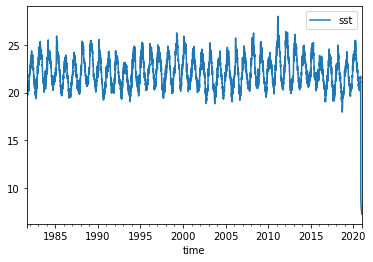

In [38]:
appended_ts_list[1].plot("time", "sst")

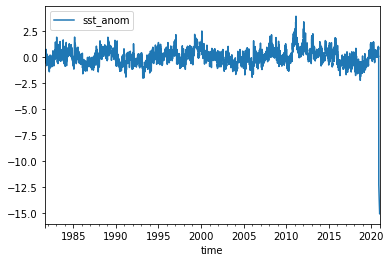

In [39]:
appended_ts_list[1].plot("time", "sst_anom")

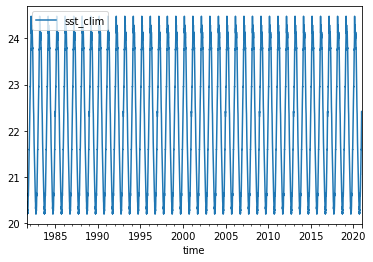

In [40]:
appended_ts_list[1].plot("time", "sst_clim")

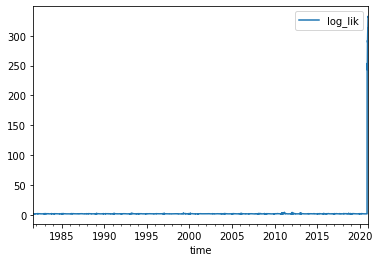

In [41]:
appended_ts_list[1].plot("time", "log_lik")

## Save the extended masked timeseries

Currently they are routed locally for QA/QC purposes

In [65]:
# Save csv file out
##### Super loop for all the LME's  ####
for i, lme in lme_info.iterrows():
    
    # lme information for saving
    lme_name = lme["lme_name"].replace(" ", "_").replace("-", "_").replace("__", "_").lower()  # Names of LME as variable names
    poly_path = lme["outer_bound_file"]           # Location to polygon file
    out_folder = f"~{box_root}RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems"
    grid_name = "OISSTv2_anom"
    
    # Path to the timeseries
    out_path = f"{out_folder}/{grid_name}_{lme_name}.csv"
    
    # And export
    appended_ts_list[i].to_csv(out_path, index = False)